Transformation Tasks
- Identifying and handling duplicated data
- Identifying and handling missing values
- Identifying and handling outliers

Loading Taks
- Load data locally
- Load data to s3 bucket

In [1]:
# libraries we need for today

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import boto3
from io import StringIO, BytesIO

In [2]:
# read the data

users_data = pd.read_pickle("../data/users_data_final.pkl")
users_data.head()

,user_id,number_transactions,total_amount_usd,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,term_deposit,date_joined,device
0,9231c446-cb16-4b2b-a7f7-ddfc8b25aaf6,3.0,2143.0,58,management,married,tertiary,False,True,False,None,261,1,-1,0,None,False,1998-08-23,mobile
1,bb92765a-08de-4963-b432-496524b39157,NaN,NaN,44,technician,single,secondary,False,True,False,None,151,1,-1,0,None,False,2008-07-15,desktop
2,573de577-49ef-42b9-83da-d3cfb817b5c1,2.0,2.0,33,entrepreneur,married,secondary,False,True,True,None,76,1,-1,0,None,False,2002-06-04,mobile
3,d6b66b9d-7c8f-4257-a682-e136f640b7e3,NaN,NaN,47,blue-collar,married,None,False,True,False,None,92,1,-1,0,None,False,1995-06-29,tablet
4,fade0b20-7594-4d9a-84cd-c02f79b1b526,1.0,1.0,33,None,single,None,False,False,False,None,198,1,-1,0,None,False,1995-08-01,mobile


In [3]:
# summary of the data

users_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45209 entries, 0 to 45215
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              45209 non-null  object        
 1   number_transactions  35210 non-null  float64       
 2   total_amount_usd     35210 non-null  float64       
 3   age                  45209 non-null  int64         
 4   job                  44921 non-null  object        
 5   marital              45209 non-null  object        
 6   education            43352 non-null  object        
 7   default              45209 non-null  bool          
 8   housing              45209 non-null  bool          
 9   loan                 45209 non-null  bool          
 10  contact              32191 non-null  object        
 11  duration             45209 non-null  int64         
 12  campaign             45209 non-null  int64         
 13  pdays                45209 non-

In [4]:
# number of numerical variables
print("# of numerical variables:",
      len(users_data.select_dtypes(['float64', 'int64', 'bool']).columns))


# of numerical variables: 11


In [5]:
# number of variables with data type object

print("# of variables with data type object:",
      len(users_data.select_dtypes(['object']).columns))


# of variables with data type object: 7


### Identifying and Removing duplicate rows

In [6]:
# Code to identify duplicated rows of data

users_data[users_data.duplicated()]

# empty data frame, so currently there is no duplicated data

,user_id,number_transactions,total_amount_usd,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,term_deposit,date_joined,device


In [7]:
users_data.duplicated().sum()

0

### Identifying and Handling Missing Data

In [8]:
# lets take this code up a level

users_data.isnull().sum()

user_id                    0
number_transactions     9999
total_amount_usd        9999
age                        0
job                      288
marital                    0
education               1857
default                    0
housing                    0
loan                       0
contact                13018
duration                   0
campaign                   0
pdays                      0
previous                   0
poutcome               36957
term_deposit               0
date_joined               30
device                    94
dtype: int64

In [9]:
def identify_missing_data(df):
    """
    This function is used to identify missing data
    
    @param df pandas DataFrame
    
    @return a DataFrame with the percentage of missing data for every feature and the data types
    """
    
    percent_missing = df.isnull().mean()
    
    missing_value_df = pd.DataFrame(percent_missing).reset_index() # convert to DataFrame
    missing_value_df = missing_value_df.rename(columns = {"index" : "variable",
                                                                0 : "percent_missing"}) # rename columns

    missing_value_df = missing_value_df.sort_values(by = ['percent_missing'], ascending = False) # sort the values
    
    data_types_df = pd.DataFrame(df.dtypes).reset_index().rename(columns = {"index" : "variable",
                                                                0 : "data_type"}) # rename columns
    
    missing_value_df = missing_value_df.merge(data_types_df, on = "variable") # join the dataframe with datatype
    
    missing_value_df.percent_missing = round(missing_value_df.percent_missing*100, 2) # format the percent_missing
    
    return missing_value_df[missing_value_df.percent_missing > 0]

In [10]:
# the function gives all variables with missing values , the data type and how much data is missing 

missing_df = identify_missing_data(users_data)
missing_df

,variable,percent_missing,data_type
0,poutcome,81.75,object
1,contact,28.80,object
2,total_amount_usd,22.12,float64
3,number_transactions,22.12,float64
4,education,4.11,object
5,job,0.64,object
6,device,0.21,object
7,date_joined,0.07,datetime64[ns]


In [11]:
print("# of variables with missing values", len(missing_df.variable))

# of variables with missing values 8


In [12]:
# number of variables with more than 70% missing data

print("number of variables with more than 70% missing data:",
      len(missing_df[missing_df.percent_missing > 70].variable))


number of variables with more than 70% missing data: 1


In [13]:
print("# of numerical variables with missing values:", 
      len(missing_df[(missing_df.data_type == "float64")].variable))


# of numerical variables with missing values: 2


In [14]:
print("# of non numerical variables with missing values:", 
      len(missing_df[(missing_df.data_type == "object") | 
         (missing_df.data_type == "datetime64[ns]")].variable))


# of non numerical variables with missing values: 6


In [15]:
# drop columns that have more than 70% missing data

col_to_drop = list(missing_df[missing_df.percent_missing > 70].variable)
users_data_cleaned = users_data.drop(col_to_drop, axis = 1)

In [16]:
# check what else needs handling or dropping
missing_df = identify_missing_data(users_data_cleaned)
missing_df

,variable,percent_missing,data_type
0,contact,28.80,object
1,total_amount_usd,22.12,float64
2,number_transactions,22.12,float64
3,education,4.11,object
4,job,0.64,object
5,device,0.21,object
6,date_joined,0.07,datetime64[ns]


In [17]:
# identify all non numerical variables and replace with Unknown

non_numerical_var = list(missing_df[(missing_df.data_type == "object")].variable)
print(non_numerical_var)

for var in non_numerical_var:
    users_data_cleaned[var].fillna("Unknown", inplace = True)

['contact', 'education', 'job', 'device']


In [18]:
# na is replaced with Unknown

users_data_cleaned.contact.value_counts()

cellular     29285
Unknown      13018
telephone     2906
Name: contact, dtype: int64

In [19]:
# check we replaced the missing values

missing_df = identify_missing_data(users_data_cleaned)
missing_df


,variable,percent_missing,data_type
0,total_amount_usd,22.12,float64
1,number_transactions,22.12,float64
2,date_joined,0.07,datetime64[ns]


In [20]:
# which features have data type object

numerical_var = list(missing_df[(missing_df.data_type == "float64")].variable)
print(numerical_var)

for var in numerical_var:
    users_data_cleaned[var].fillna(0, inplace = True)

['total_amount_usd', 'number_transactions']


In [21]:
identify_missing_data(users_data_cleaned)

,variable,percent_missing,data_type
0,date_joined,0.07,datetime64[ns]


In [22]:
# check the summary of the data to make sure none of the variables were corrupted

users_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45209 entries, 0 to 45215
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              45209 non-null  object        
 1   number_transactions  45209 non-null  float64       
 2   total_amount_usd     45209 non-null  float64       
 3   age                  45209 non-null  int64         
 4   job                  45209 non-null  object        
 5   marital              45209 non-null  object        
 6   education            45209 non-null  object        
 7   default              45209 non-null  bool          
 8   housing              45209 non-null  bool          
 9   loan                 45209 non-null  bool          
 10  contact              45209 non-null  object        
 11  duration             45209 non-null  int64         
 12  campaign             45209 non-null  int64         
 13  pdays                45209 non-

### Identify and Remove Outliers

In [23]:
users_data_cleaned.describe()

,number_transactions,total_amount_usd,age,duration,campaign,pdays,previous
count,45209.000000,45209.000000,45209.000000,45209.000000,45209.000000,45209.000000,45209.000000
mean,3.097436,1066.539826,40.935853,258.153067,2.763897,40.199651,0.580349
std,3.749104,2762.588385,10.618653,257.525446,3.098076,100.130586,2.303489
min,0.000000,-8019.000000,18.000000,0.000000,1.000000,-1.000000,0.000000
25%,2.000000,0.000000,33.000000,103.000000,1.000000,-1.000000,0.000000
50%,2.000000,211.000000,39.000000,180.000000,2.000000,-1.000000,0.000000
75%,3.000000,1022.000000,48.000000,319.000000,3.000000,-1.000000,0.000000
max,20.000000,102127.000000,95.000000,4918.000000,63.000000,871.000000,275.000000


In [24]:
# calculates the 25th percentile

q1 = np.percentile(users_data_cleaned.number_transactions, 25)
q1

2.0

In [25]:
# calculates the 75th percentile

q3 = np.percentile(users_data_cleaned.number_transactions, 75)
q3

3.0

In [26]:
# calculates the iqr

iqr = q3 - q1
iqr

1.0

In [27]:
# calculates the lower bound and upper bound

lb = q1 - 1.5*iqr
ub = q3 + 1.5*iqr

print("The lower bound is:",lb)
print("The upper bound is:",ub)

The lower bound is: 0.5
The upper bound is: 4.5


In [28]:
def identify_upper_and_lower_bound(df, var):
    """This definition calculates the outliers of a variable using iqr
    
    @param df pandas DataFrame
    @param var str 
    
    """
    
    q1 = np.percentile(df[var], 25)
    q3 = np.percentile(df[var], 75)
    iqr = q3 - q1
    
    ub = q3 + 1.5*iqr
    lb = q1 - 1.5*iqr
    
    print(f"The upper bound for {var} is:", ub)
    print(f"The lower bound for {var} is:", lb)
    
    return ub, lb

In [29]:
# TO DO: Check this function works correctly

In [30]:
ub, lb = identify_upper_and_lower_bound(users_data_cleaned, "number_transactions")

The upper bound for number_transactions is: 4.5
The lower bound for number_transactions is: 0.5


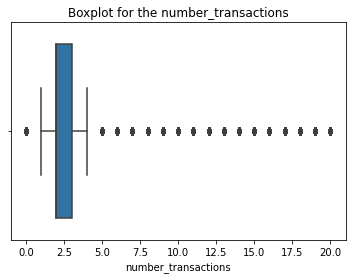

In [31]:
sns.boxplot(x = users_data_cleaned.number_transactions)
plt.title("Boxplot for the number_transactions");

In [32]:
# number of transactions above UB

users_data_cleaned[users_data_cleaned.number_transactions > ub].shape[0]

5776

In [33]:
# number of transactions below lb

users_data_cleaned[users_data_cleaned.number_transactions < lb].shape[0]

9999

In [34]:
# option 1- identfiying all cases where number transactions is between lb and ub

users_data_wout_outliers = users_data_cleaned[
    users_data_cleaned["number_transactions"].between(lb,ub)]
users_data_wout_outliers.head()

,user_id,number_transactions,total_amount_usd,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,term_deposit,date_joined,device
0,9231c446-cb16-4b2b-a7f7-ddfc8b25aaf6,3.0,2143.0,58,management,married,tertiary,False,True,False,Unknown,261,1,-1,0,False,1998-08-23,mobile
2,573de577-49ef-42b9-83da-d3cfb817b5c1,2.0,2.0,33,entrepreneur,married,secondary,False,True,True,Unknown,76,1,-1,0,False,2002-06-04,mobile
4,fade0b20-7594-4d9a-84cd-c02f79b1b526,1.0,1.0,33,Unknown,single,Unknown,False,False,False,Unknown,198,1,-1,0,False,1995-08-01,mobile
5,c6aee0d4-2a86-4bac-827b-c6d33b5933e6,2.0,231.0,35,management,married,tertiary,False,True,False,Unknown,139,1,-1,0,False,2000-06-21,desktop
6,1fa7d4fb-3e4a-463a-ba4b-08f824945e45,2.0,447.0,28,management,single,tertiary,False,True,True,Unknown,217,1,-1,0,False,1996-02-22,mobile


In [35]:
users_data_wout_outliers.shape

(29434, 18)

In [36]:
# option 2 - for removing the outliers

users_data_wout_outliers = users_data_cleaned[(users_data_cleaned.number_transactions <= ub)
                  & (users_data_cleaned.number_transactions >= lb)]

In [37]:
# original shape
print(users_data.shape)
# shape of data after handling missing data
print(users_data_cleaned.shape)
# shape of data after removing outliers
print(users_data_wout_outliers.shape)

(45209, 19)
(45209, 18)
(29434, 18)


In [38]:
users_data_wout_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29434 entries, 0 to 45215
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              29434 non-null  object        
 1   number_transactions  29434 non-null  float64       
 2   total_amount_usd     29434 non-null  float64       
 3   age                  29434 non-null  int64         
 4   job                  29434 non-null  object        
 5   marital              29434 non-null  object        
 6   education            29434 non-null  object        
 7   default              29434 non-null  bool          
 8   housing              29434 non-null  bool          
 9   loan                 29434 non-null  bool          
 10  contact              29434 non-null  object        
 11  duration             29434 non-null  int64         
 12  campaign             29434 non-null  int64         
 13  pdays                29434 non-

### Loading the data - locally

In [39]:
# save the data without outliers and missing data to the data folder as .csv file
# could also create sub folders, raw and cleaned

users_data_wout_outliers.to_csv("../data/users_data_final_cleaned.csv", index = False)
print("loaded to data folder")

# the names may feel weird, but in the real world we would replace the original file with our changes

loaded to data folder


In [40]:
# read the data to check if it worked

test = pd.read_csv("../data/users_data_final_cleaned.csv")
test.head()

,user_id,number_transactions,total_amount_usd,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,term_deposit,date_joined,device
0,9231c446-cb16-4b2b-a7f7-ddfc8b25aaf6,3.0,2143.0,58,management,married,tertiary,False,True,False,Unknown,261,1,-1,0,False,1998-08-23,mobile
1,573de577-49ef-42b9-83da-d3cfb817b5c1,2.0,2.0,33,entrepreneur,married,secondary,False,True,True,Unknown,76,1,-1,0,False,2002-06-04,mobile
2,fade0b20-7594-4d9a-84cd-c02f79b1b526,1.0,1.0,33,Unknown,single,Unknown,False,False,False,Unknown,198,1,-1,0,False,1995-08-01,mobile
3,c6aee0d4-2a86-4bac-827b-c6d33b5933e6,2.0,231.0,35,management,married,tertiary,False,True,False,Unknown,139,1,-1,0,False,2000-06-21,desktop
4,1fa7d4fb-3e4a-463a-ba4b-08f824945e45,2.0,447.0,28,management,single,tertiary,False,True,True,Unknown,217,1,-1,0,False,1996-02-22,mobile


In [41]:
# the .csv file loses the date format, so we would need to fix this

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29434 entries, 0 to 29433
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              29434 non-null  object 
 1   number_transactions  29434 non-null  float64
 2   total_amount_usd     29434 non-null  float64
 3   age                  29434 non-null  int64  
 4   job                  29434 non-null  object 
 5   marital              29434 non-null  object 
 6   education            29434 non-null  object 
 7   default              29434 non-null  bool   
 8   housing              29434 non-null  bool   
 9   loan                 29434 non-null  bool   
 10  contact              29434 non-null  object 
 11  duration             29434 non-null  int64  
 12  campaign             29434 non-null  int64  
 13  pdays                29434 non-null  int64  
 14  previous             29434 non-null  int64  
 15  term_deposit         29434 non-null 

In [42]:
# save the data without outliers and missing data to the data folder as a .pkl file
# could also create sub folders, raw and cleaned

users_data_wout_outliers.to_pickle("../data/users_data_final_cleaned.pkl")

In [43]:
test = pd.read_pickle("../data/users_data_final_cleaned.pkl")
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29434 entries, 0 to 45215
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              29434 non-null  object        
 1   number_transactions  29434 non-null  float64       
 2   total_amount_usd     29434 non-null  float64       
 3   age                  29434 non-null  int64         
 4   job                  29434 non-null  object        
 5   marital              29434 non-null  object        
 6   education            29434 non-null  object        
 7   default              29434 non-null  bool          
 8   housing              29434 non-null  bool          
 9   loan                 29434 non-null  bool          
 10  contact              29434 non-null  object        
 11  duration             29434 non-null  int64         
 12  campaign             29434 non-null  int64         
 13  pdays                29434 non-

In [44]:
test.head()

,user_id,number_transactions,total_amount_usd,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,term_deposit,date_joined,device
0,9231c446-cb16-4b2b-a7f7-ddfc8b25aaf6,3.0,2143.0,58,management,married,tertiary,False,True,False,Unknown,261,1,-1,0,False,1998-08-23,mobile
2,573de577-49ef-42b9-83da-d3cfb817b5c1,2.0,2.0,33,entrepreneur,married,secondary,False,True,True,Unknown,76,1,-1,0,False,2002-06-04,mobile
4,fade0b20-7594-4d9a-84cd-c02f79b1b526,1.0,1.0,33,Unknown,single,Unknown,False,False,False,Unknown,198,1,-1,0,False,1995-08-01,mobile
5,c6aee0d4-2a86-4bac-827b-c6d33b5933e6,2.0,231.0,35,management,married,tertiary,False,True,False,Unknown,139,1,-1,0,False,2000-06-21,desktop
6,1fa7d4fb-3e4a-463a-ba4b-08f824945e45,2.0,447.0,28,management,single,tertiary,False,True,True,Unknown,217,1,-1,0,False,1996-02-22,mobile


In [45]:
users_data_wout_outliers.to_pickle("../data/users_data_final_cleaned.pkl")

In [46]:
pd.read_csv("../data/users_data_final_cleaned.csv").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29434 entries, 0 to 29433
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              29434 non-null  object 
 1   number_transactions  29434 non-null  float64
 2   total_amount_usd     29434 non-null  float64
 3   age                  29434 non-null  int64  
 4   job                  29434 non-null  object 
 5   marital              29434 non-null  object 
 6   education            29434 non-null  object 
 7   default              29434 non-null  bool   
 8   housing              29434 non-null  bool   
 9   loan                 29434 non-null  bool   
 10  contact              29434 non-null  object 
 11  duration             29434 non-null  int64  
 12  campaign             29434 non-null  int64  
 13  pdays                29434 non-null  int64  
 14  previous             29434 non-null  int64  
 15  term_deposit         29434 non-null 

In [47]:
# the pickle file keeps the data types for every variable

pd.read_pickle("../data/users_data_final_cleaned.pkl").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29434 entries, 0 to 45215
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              29434 non-null  object        
 1   number_transactions  29434 non-null  float64       
 2   total_amount_usd     29434 non-null  float64       
 3   age                  29434 non-null  int64         
 4   job                  29434 non-null  object        
 5   marital              29434 non-null  object        
 6   education            29434 non-null  object        
 7   default              29434 non-null  bool          
 8   housing              29434 non-null  bool          
 9   loan                 29434 non-null  bool          
 10  contact              29434 non-null  object        
 11  duration             29434 non-null  int64         
 12  campaign             29434 non-null  int64         
 13  pdays                29434 non-

### Loading the data as a .csv to a s3 bucket 

In [48]:
# read the environment variables

AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""
AWS_S3_BUCKET = ""

In [49]:
# use boto3 to connect to AWS s3 buckets

s3_client = boto3.client(
    "s3",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)


In [50]:
# this step is not usually this complicated
# write the file to s3 bucket

key = "sh_users_data_final.csv" # define the name of the file

csv_buffer = StringIO() # create buffer to temporarily store the Data Frame

users_data_wout_outliers.to_csv(csv_buffer, index=False) # code to write the data frame as csv file

response = s3_client.put_object(
        Bucket=AWS_S3_BUCKET, Key=key, Body=csv_buffer.getvalue()
    ) # this code writes the temp stored csv file and writes to s3

print("Dataframe is saved as CSV in S3 bucket.") # prints a statement to let us know the file has been written

# check the file is loaded to s3

Dataframe is saved as CSV in S3 bucket.


In [51]:
# code to read an s3 cav file

key = "sh_users_data_final.csv" # specify the file name

response = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key=key)
sarah_data = pd.read_csv(response.get("Body"))

In [52]:
sarah_data.shape

(29434, 18)

In [53]:
sarah_data.head()

,user_id,number_transactions,total_amount_usd,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,term_deposit,date_joined,device
0,9231c446-cb16-4b2b-a7f7-ddfc8b25aaf6,3.0,2143.0,58,management,married,tertiary,False,True,False,Unknown,261,1,-1,0,False,1998-08-23,mobile
1,573de577-49ef-42b9-83da-d3cfb817b5c1,2.0,2.0,33,entrepreneur,married,secondary,False,True,True,Unknown,76,1,-1,0,False,2002-06-04,mobile
2,fade0b20-7594-4d9a-84cd-c02f79b1b526,1.0,1.0,33,Unknown,single,Unknown,False,False,False,Unknown,198,1,-1,0,False,1995-08-01,mobile
3,c6aee0d4-2a86-4bac-827b-c6d33b5933e6,2.0,231.0,35,management,married,tertiary,False,True,False,Unknown,139,1,-1,0,False,2000-06-21,desktop
4,1fa7d4fb-3e4a-463a-ba4b-08f824945e45,2.0,447.0,28,management,single,tertiary,False,True,True,Unknown,217,1,-1,0,False,1996-02-22,mobile


### (Optional) Loading the data as a .pkl file to a s3 bucket 

In [54]:
# this step is not usually this complicated
# write the file to s3 bucket

key = "sh_users_data_final.pkl" # define the name of the file

pkl_buffer = BytesIO() # create buffer to temporarily store the Data Frame. 

users_data_wout_outliers.to_pickle(pkl_buffer) # code to write the data frame as pkl file

response = s3_client.put_object(
        Bucket=AWS_S3_BUCKET, Key=key, Body=pkl_buffer.getvalue()
    ) # this code writes the temp stored csv file and writes to s3

print("Dataframe is saved as pickle file in S3 bucket.") # prints a statement to let us know the file has been written

# check the file is loaded to s3

Dataframe is saved as pickle file in S3 bucket.


In [55]:
# TO DO- update this code as not working from me
# Reading pickle file from S3 Bucket

key="bb_user_data_final.pkl"
response = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key=key)
test = pd.read_pickle(response.get("Body"))

AttributeError: 'StreamingBody' object has no attribute 'seek'